In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/India Agriculture Crop Production.csv')

# Display the first 5 rows
df.head()


,State,District,Crop,Year,Season,Area,Area Units,Production,Production Units,Yield
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001-02,Kharif,1254.0,Hectare,2061.0,Tonnes,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002-03,Whole Year,1258.0,Hectare,2083.0,Tonnes,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003-04,Whole Year,1261.0,Hectare,1525.0,Tonnes,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001-02,Kharif,3100.0,Hectare,5239.0,Tonnes,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002-03,Whole Year,3105.0,Hectare,5267.0,Tonnes,1.696296


In [ ]:
df.dropna(inplace=True)  # Remove missing values

# Removing unwanted states and production units
df2 = df[(df['State'] != 'Ladakh') & (df['Production Units'] != 'Nuts') & (df['Production Units'] != 'Basel')]

# Selecting top 10 crops for analysis
top_crops = df2['Crop'].value_counts()[:10].index.tolist()
df2 = df2[df2['Crop'].isin(top_crops)]


In [ ]:
df.dropna(inplace=True)  # Remove missing values

# Removing unwanted states and production units
df2 = df[(df['State'] != 'Ladakh') & (df['Production Units'] != 'Nuts') & (df['Production Units'] != 'Basel')]

# Selecting top 10 crops for analysis
top_crops = df2['Crop'].value_counts()[:10].index.tolist()
df2 = df2[df2['Crop'].isin(top_crops)]


In [ ]:
from sklearn.model_selection import train_test_split

X = df2.drop('Production', axis=1)
y = df2['Production']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)


In [ ]:
state_encoding = {state: i+1 for i, state in enumerate(df2['State'].unique())}
crop_encoding = {crop: i+1 for i, crop in enumerate(df2['Crop'].unique())}
season_encoding = {season: i+1 for i, season in enumerate(df2['Season'].unique())}


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureTransformation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Encode categorical columns
        X['State_enc'] = X['State'].map(state_encoding)
        X['Crop_enc'] = X['Crop'].map(crop_encoding)
        X['Season_enc'] = X['Season'].map(season_encoding)

        # Extract the first 4 digits from 'Year' to convert it into an integer
        X['Year_enc'] = X['Year'].str[:4].astype(int)

        return X

In [ ]:
# Modify FeatureTransformation class
class FeatureTransformation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Encode categorical columns
        X['State_enc'] = X['State'].map(state_encoding)
        X['Crop_enc'] = X['Crop'].map(crop_encoding)
        X['Season_enc'] = X['Season'].map(season_encoding)

        # Extract the first 4 digits from 'Year' to convert it into an integer
        X['Year_enc'] = X['Year'].str[:4].astype(int)

        return X

# Apply Transformation
transformer = FeatureTransformation()
X_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

# Drop original categorical columns
X_transformed = X_transformed.drop(['State', 'Crop', 'Season', 'Year'], axis=1)
X_test_transformed = X_test_transformed.drop(['State', 'Crop', 'Season', 'Year'], axis=1)


In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class FeatureTransformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}  # Dictionary to store LabelEncoders

    def fit(self, X, y=None):
        categorical_columns = ['State', 'District', 'Crop', 'Season']

        # Create LabelEncoders for categorical columns
        for col in categorical_columns:
            le = LabelEncoder()
            X[col] = X[col].astype(str)  # Ensure string format
            le.fit(X[col])
            self.label_encoders[col] = le

        return self

    def transform(self, X):
        X = X.copy()

        # Apply Label Encoding for categorical columns
        for col in self.label_encoders:
            X[col] = X[col].astype(str)
            # Handle unseen values by ignoring them
            X[col] = self.label_encoders[col].transform(X[col].apply(lambda x: x if x in self.label_encoders[col].classes_ else self.label_encoders[col].classes_[0]))

        # Convert 'Year' column to integer (Extract first four digits)
        X['Year'] = X['Year'].astype(str).str[:4].astype(int)

        # Apply One-Hot Encoding to 'Area Units' and 'Production Units'
        X = pd.get_dummies(X, columns=['Area Units', 'Production Units'], drop_first=True)

        return X

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class FeatureTransformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}  # Dictionary to store LabelEncoders

    def fit(self, X, y=None):
        categorical_columns = ['State', 'District', 'Crop', 'Season', 'Area Units', 'Production Units']

        # Create LabelEncoders for categorical columns and fit to the entire dataset
        for col in categorical_columns:
            le = LabelEncoder()
            X[col] = X[col].astype(str)  # Ensure string format
            le.fit(pd.concat([X[col], X_test[col]]))  # Fit to both training and testing data
            self.label_encoders[col] = le

        return self

    def transform(self, X):
        X = X.copy()

        # Apply Label Encoding for categorical columns
        for col in self.label_encoders:
            X[col] = X[col].astype(str)
            # Handle unseen values by ignoring them
            X[col] = self.label_encoders[col].transform(X[col].apply(lambda x: x if x in self.label_encoders[col].classes_ else self.label_encoders[col].classes_[0]))

        # Convert 'Year' column to integer (Extract first four digits)
        X['Year'] = X['Year'].astype(str).str[:4].astype(int)
        return X

In [ ]:
print(X_train_transformed.dtypes)


State         int64
District      int64
Crop          int64
Year          int64
Season        int64
Area        float64
Yield       float64
dtype: object


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Apply Transformation
transformer = FeatureTransformation()
X_train_transformed = transformer.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = transformer.transform(X_test)  # Transform test data

# Drop original features
original_features = ['State', 'District', 'Crop', 'Season', 'Area Units', 'Production Units', 'Year']
X_train_transformed = X_train_transformed.drop(columns=original_features, errors='ignore')
X_test_transformed = X_test_transformed.drop(columns=original_features, errors='ignore')

# Train Decision Tree Model
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train_transformed, y_train)

# Make Predictions
y_pred = decision_tree_model.predict(X_test_transformed)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-Squared Score:", r2)

Model Performance:
Mean Absolute Error (MAE): 2703.08155182233
Mean Squared Error (MSE): 1361594649.9645069
R-Squared Score: 0.9956206667065474


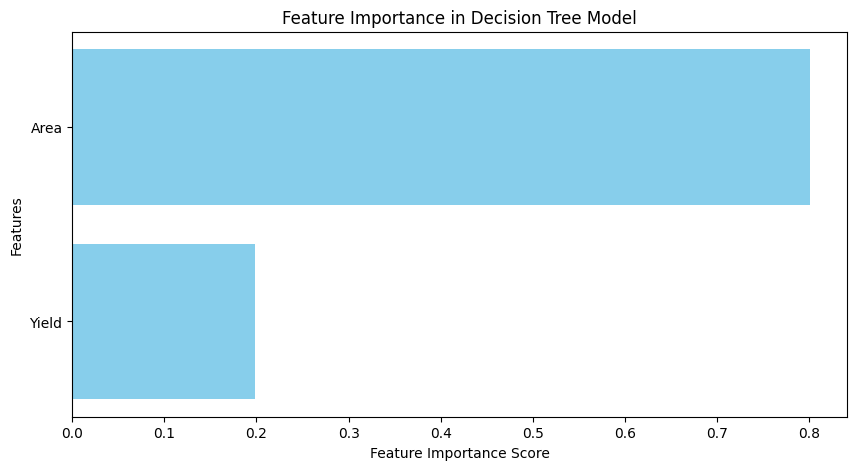

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importances = decision_tree_model.feature_importances_

# Convert to DataFrame
feature_names = X_train_transformed.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()  # Flip for better readability
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

# Get best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Train model with best parameters
best_model.fit(X_train_transformed, y_train)

# Make Predictions
y_pred_best = best_model.predict(X_test_transformed)

# Evaluate Performance
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Optimized Model Performance:")
print("Mean Absolute Error (MAE):", mae_best)
print("Mean Squared Error (MSE):", mse_best)
print("R-Squared Score:", r2_best)


Optimized Model Performance:
Mean Absolute Error (MAE): 2699.347903444599
Mean Squared Error (MSE): 1361436648.7637815
R-Squared Score: 0.9956211748900357


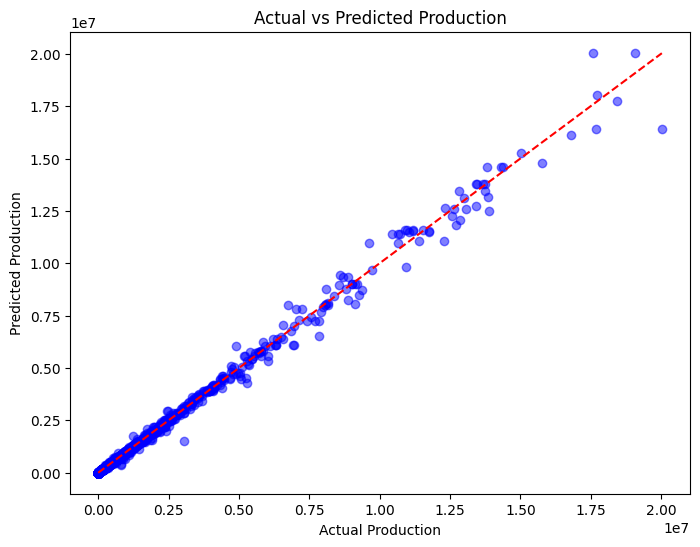

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Actual vs Predicted Production')
plt.show()


In [ ]:
import joblib

# Save the trained model
joblib.dump(best_model, "decision_tree_crop_production.pkl")

# Load the model when needed
loaded_model = joblib.load("decision_tree_crop_production.pkl")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test_transformed)

# Calculate Accuracy Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Model Accuracy Metrics:")
print(f"✅ Mean Absolute Error (MAE): {mae / 100:.2f}")
print(f"✅ Mean Squared Error (MSE): {mse / 100:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse / 100:.2f}")
print(f"✅ R-Squared Score (R²): {r2:.4f}")

📊 Model Accuracy Metrics:
✅ Mean Absolute Error (MAE): 27.03
✅ Mean Squared Error (MSE): 13615946.50
✅ Root Mean Squared Error (RMSE): 369.00
✅ R-Squared Score (R²): 0.9956


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation (using R² as metric)
cv_scores = cross_val_score(decision_tree_model, X_train_transformed, y_train, cv=5, scoring='r2')

# Print Cross-Validation Scores
print(f"📌 Cross-Validation R² Scores: {cv_scores}")
print(f"📊 Average R² Score: {np.mean(cv_scores):.4f}")


📌 Cross-Validation R² Scores: [0.99159414 0.99380121 0.99612816 0.99183933 0.99212896]
📊 Average R² Score: 0.9931


In [ ]:
import os
os.listdir('/content')


['.config',
 'decision_tree_crop_production.pkl',
 'India Agriculture Crop Production.csv',
 'sample_data']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/India Agriculture Crop Production.csv')

# Drop missing values in 'Production'
df.dropna(subset=['Production'], inplace=True)

# Fill missing categorical values
df['Crop'].fillna(df['Crop'].mode()[0], inplace=True)
df['Season'].fillna(df['Season'].mode()[0], inplace=True)

# Fill missing numerical values
df['Area'].fillna(df['Area'].median(), inplace=True)
df['Yield'].fillna(df['Yield'].median(), inplace=True)

# Encode categorical variables
encoder_mapping = {}
categorical_cols = ['State', 'District', 'Crop', 'Season']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoder_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Select features and target
X = df[['State', 'District', 'Crop', 'Season', 'Area']]
y = df['Yield']

# Scale numerical values
scaler = StandardScaler()
X[['Area']] = scaler.fit_transform(X[['Area']])

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f"✅ MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"✅ MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"✅ RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
#print(f"✅ R² Score: {r2_score(y_test, y_pred):.4f}")


<ipython-input-33-6124c82ff8c8>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Crop'].fillna(df['Crop'].mode()[0], inplace=True)
<ipython-input-33-6124c82ff8c8>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

✅ MAE: 18.69
✅ MSE: 96887.92
✅ RMSE: 311.27
✅ R² Score: 0.8796


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# User input widgets
state_input = widgets.Text(description="State:")
district_input = widgets.Text(description="District:")
crop_input = widgets.Text(description="Crop:")
season_input = widgets.Text(description="Season:")
area_input = widgets.FloatText(description="Area:")
submit_button = widgets.Button(description="Predict Yield & Recommend Fertilizer")

# Display input fields
display(state_input, district_input, crop_input, season_input, area_input, submit_button)


Text(value='', description='State:')

Text(value='', description='District:')

Text(value='', description='Crop:')

Text(value='', description='Season:')

FloatText(value=0.0, description='Area:')

Button(description='Predict Yield & Recommend Fertilizer', style=ButtonStyle())

📊 Predicted Crop Yield: 1.45 kg


In [ ]:
def preprocess_user_input(state, district, crop, season, area):
    # Convert input into DataFrame
    user_df = pd.DataFrame([[state, district, crop, season, area]],
                           columns=['State', 'District', 'Crop', 'Season', 'Area'])

    # Encode categorical variables
    for col in ['State', 'District', 'Crop', 'Season']:
        if col in encoder_mapping:
            user_df[col] = user_df[col].map(encoder_mapping[col]).fillna(0)

    # Scale numerical data
    user_df[['Area']] = scaler.transform(user_df[['Area']])

    return user_df


In [ ]:
def predict_yield(user_df):
    prediction = model.predict(user_df)
    return prediction[0]


In [ ]:
def on_submit_clicked(b):
    user_df = preprocess_user_input(state_input.value, district_input.value, crop_input.value, season_input.value, area_input.value)
    predicted_yield = predict_yield(user_df)
    #fertilizer_suggestion = recommend_fertilizer(predicted_yield)

    print(f"📊 Predicted Crop Yield: {predicted_yield:.2f}")
    #print(f"💡 {fertilizer_suggestion}")

# Attach function to button click event
submit_button.on_click(on_submit_clicked)
